In [4]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, mean_squared_error
from sklearn.metrics import roc_auc_score, average_precision_score


FOLDER_PATH = "/home/juan/Work/Midterm project/splited/"
X_PATH = os.path.join(FOLDER_PATH, "X_data.npz")
Y_PATH = os.path.join(FOLDER_PATH, "Y_data.npz")
COLS_PATH = os.path.join(FOLDER_PATH, "feature_names.json")

# --- PART 1: DATA PREPARATION (Run only if NPZ files don't exist) ---
if not os.path.exists(X_PATH) or not os.path.exists(Y_PATH):
    print("NPZ files not found. Starting processing of CSV files...")
    
    FILE_PATTERN = os.path.join(FOLDER_PATH, "processed_*.csv")
    files = sorted(glob.glob(FILE_PATTERN))
    print(f"Found {len(files)} processed files.")

    if len(files) == 0:
        raise FileNotFoundError("No 'processed_*.csv' files found in the directory.")

    # 1. Read first file to determine column structure
    print("Reading headers from first file...")
    first_df = pd.read_csv(files[0], nrows=5)
    cols = first_df.columns
    x_cols = [c for c in cols if c.startswith("x ")]
    y_cols = [c for c in cols if c.startswith("y ")]
    
    # Save feature names for later use (Feature Importance)
    with open(COLS_PATH, 'w') as f:
        json.dump(x_cols, f)

    print(f"Detected {len(x_cols)} Features and {len(y_cols)} Targets.")

    X_list = []
    Y_list = []

    # 2. Loop through all files and convert to Sparse
    for f in files:
        print(f"Converting: {os.path.basename(f)}")
        df = pd.read_csv(f)
        
        x_data = df[x_cols].fillna(0).values.astype(np.float32)
        y_data = df[y_cols].fillna(0).values.astype(np.float32)
        
        X_list.append(sparse.csr_matrix(x_data))
        Y_list.append(sparse.csr_matrix(y_data))
        
        del df, x_data, y_data # Free RAM

    # 3. Stack and Save
    print("Stacking matrices...")
    X_final = sparse.vstack(X_list)
    Y_final = sparse.vstack(Y_list)

    print(f"Saving to {FOLDER_PATH}...")
    sparse.save_npz(X_PATH, X_final)
    sparse.save_npz(Y_PATH, Y_final)
    print("Processing complete.")

else:
    print("Found existing NPZ files. Skipping CSV processing.")

# --- PART 2: LOAD DATA & PREPARE FOR MODELING ---
print("Loading Data from disk...")
# --- RELOAD DATA TO ENSURE FRESH START ---
print("Loading Data...")
# Assuming X_PATH and Y_PATH are defined as before
X = sparse.load_npz(X_PATH)
Y = sparse.load_npz(Y_PATH)

print(f"Input Shape: {X.shape}")
print(f"Target Shape: {Y.shape}") # Should be (661271, 10488)

# Split the SPARSE matrices directly
# We do not densify yet to save RAM
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Data Split Complete.")

# Load feature names if needed later
if os.path.exists(COLS_PATH):
    with open(COLS_PATH, 'r') as f:
        feature_names = json.load(f)
else:
    feature_names = [f"feature_{i}" for i in range(X.shape[1])]

# 1. Select Target (Most Frequent Reaction)
# Sum columns to find which reaction happens most often
col_sums = np.array(Y.sum(axis=0)).flatten()
target_idx = np.argmax(col_sums)
y_target = Y[:, target_idx].toarray().ravel()

print(f"Target Index selected: {target_idx}")
print(f"Positive Cases: {int(sum(y_target))} / {len(y_target)}")

# 2. Calculate Class Weight (for imbalanced learning)
pos_count = sum(y_target)
neg_count = len(y_target) - pos_count
scale_weight = neg_count / (pos_count + 1e-5)
print(f"Calculated Class Weight (neg/pos): {scale_weight:.2f}")

# 3. Train/Test Split
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.2, random_state=42)

# --- PART 3: EVALUATION SETUP ---
results_table = []
roc_curves = {}

from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score

# Initialize dictionaries to store curve data
roc_curves = {}
pr_curves = {}   
results_table = []

def log_result(name, y_true, y_prob):
    # 1. Calculate Metrics
    y_prob = np.nan_to_num(y_prob)
    
    # ROC-AUC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # PR-AUC (Average Precision)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    
    # F1 Score 
    y_pred = (y_prob > 0.5).astype(int)
    f1 = f1_score(y_true, y_pred)
    
    # 2. Log Scalar Results
    results_table.append({
        "Model": name, 
        "ROC-AUC": roc_auc, 
        "PR-AUC": pr_auc,  
        "F1": f1
    })
    
    # 3. Store Curve Data for Plotting
    roc_curves[name] = (fpr, tpr, roc_auc)
    pr_curves[name] = (recall, precision, pr_auc) 
    
    print(f"✅ {name}: ROC-AUC={roc_auc:.4f} | PR-AUC={pr_auc:.4f}")

print("\nSetup Complete. Data is ready fZor training models.")

NPZ files not found. Starting processing of CSV files...
Found 133 processed files.
Reading headers from first file...
Detected 5286 Features and 10488 Targets.
Converting: processed_1.csv
Converting: processed_10.csv
Converting: processed_100.csv
Converting: processed_101.csv
Converting: processed_102.csv
Converting: processed_103.csv
Converting: processed_104.csv
Converting: processed_105.csv
Converting: processed_106.csv
Converting: processed_107.csv
Converting: processed_108.csv
Converting: processed_109.csv
Converting: processed_11.csv
Converting: processed_110.csv
Converting: processed_111.csv
Converting: processed_112.csv
Converting: processed_113.csv
Converting: processed_114.csv
Converting: processed_115.csv
Converting: processed_116.csv
Converting: processed_117.csv
Converting: processed_118.csv
Converting: processed_119.csv
Converting: processed_12.csv
Converting: processed_120.csv
Converting: processed_121.csv
Converting: processed_122.csv
Converting: processed_123.csv
Conv

In [5]:
from sklearn.linear_model import LogisticRegression
print("--- Training Ridge (Logistic L2) ---")
# class_weight='balanced' uses the inverse frequency automatically
ridge = LogisticRegression(penalty='l2', solver='liblinear', class_weight='balanced')
ridge.fit(X_train, y_train)

# Predict Probabilities (column 1 is the probability of class '1')
preds = ridge.predict_proba(X_test)[:, 1]
log_result("Ridge", y_test, preds)

--- Training Ridge (Logistic L2) ---
✅ Ridge: ROC-AUC=0.8100 | PR-AUC=0.2512


In [6]:
print("--- Training Lasso (Logistic L1) ---")
lasso = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced')
lasso.fit(X_train, y_train)

preds = lasso.predict_proba(X_test)[:, 1]
log_result("Lasso", y_test, preds)

--- Training Lasso (Logistic L1) ---
✅ Lasso: ROC-AUC=0.8101 | PR-AUC=0.2511


In [7]:
from sklearn.ensemble import RandomForestClassifier
print("--- Training Random Forest ---")
# Limited depth to prevent OOM, n_jobs=-1 for speed
rf = RandomForestClassifier(n_estimators=50, max_depth=15, n_jobs=-1, class_weight='balanced')
rf.fit(X_train, y_train)

preds = rf.predict_proba(X_test)[:, 1]
log_result("Random Forest", y_test, preds)

--- Training Random Forest ---
✅ Random Forest: ROC-AUC=0.7788 | PR-AUC=0.2268


In [8]:
import xgboost as xgb
from sklearn.metrics import classification_report
print("--- Training XGBoost ---")
# scale_pos_weight manually sets the penalty for the positive class
xgb_model = xgb.XGBClassifier(
    n_estimators=100, 
    scale_pos_weight=scale_weight, 
    eval_metric='logloss',
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

preds = xgb_model.predict_proba(X_test)[:, 1]
log_result("XGBoost", y_test, preds)

--- Training XGBoost ---
✅ XGBoost: ROC-AUC=0.8232 | PR-AUC=0.3092


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print("--- Training PyTorch (Deep NN) ---")

# 1. Dataset
class TorchDS(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i):
        # Convert sparse row to dense tensor
        return torch.tensor(self.X[i].toarray(), dtype=torch.float32).squeeze(), self.y[i]

train_dl = DataLoader(TorchDS(X_train, y_train), batch_size=64, shuffle=True)
test_dl = DataLoader(TorchDS(X_test, y_test), batch_size=64, shuffle=False)

# 2 Architecture
class DeepDrugNet(nn.Module):
    def __init__(self, input_dim):
        super(DeepDrugNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),         # Prevent overfitting
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)         # Output Logits
        )
    def forward(self, x):
        return self.net(x)

# 3. Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pt = DeepDrugNet(X.shape[1]).to(device)

# Weighted Loss
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([scale_weight]).to(device))
optimizer = optim.Adam(model_pt.parameters(), lr=0.0005) # Lower LR for deep net

# 4. Train
model_pt.train()
for epoch in range(5): # Increased epochs for deep net
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model_pt(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_dl):.4f}")

# 5. Predict
model_pt.eval()
pt_preds = []
with torch.no_grad():
    for xb, _ in test_dl:
        xb = xb.to(device)
        # Apply Sigmoid here because model outputs Logits
        pt_preds.extend(torch.sigmoid(model_pt(xb)).cpu().numpy().flatten().tolist())

log_result("Neuron Network", y_test, np.array(pt_preds))

--- Training PyTorch (Deep NN) ---
Epoch 1 Loss: 1.0118
Epoch 2 Loss: 0.9788
Epoch 3 Loss: 0.9688
Epoch 4 Loss: 0.9642
Epoch 5 Loss: 0.9601
✅ Neuron Network: ROC-AUC=0.8149 | PR-AUC=0.2724


Results table saved to: /home/juan/Work/Midterm project/splited/final_comprehensive_results.csv

Top Models by PR-AUC:
            Model    PR-AUC   ROC-AUC        F1
3         XGBoost  0.309172  0.823245  0.343950
4  Neuron Network  0.272410  0.814858  0.315965
0           Ridge  0.251232  0.810013  0.314193
1           Lasso  0.251149  0.810114  0.314624
2   Random Forest  0.226751  0.778782  0.265778

ROC Curve saved to: roc_curve_plot.png


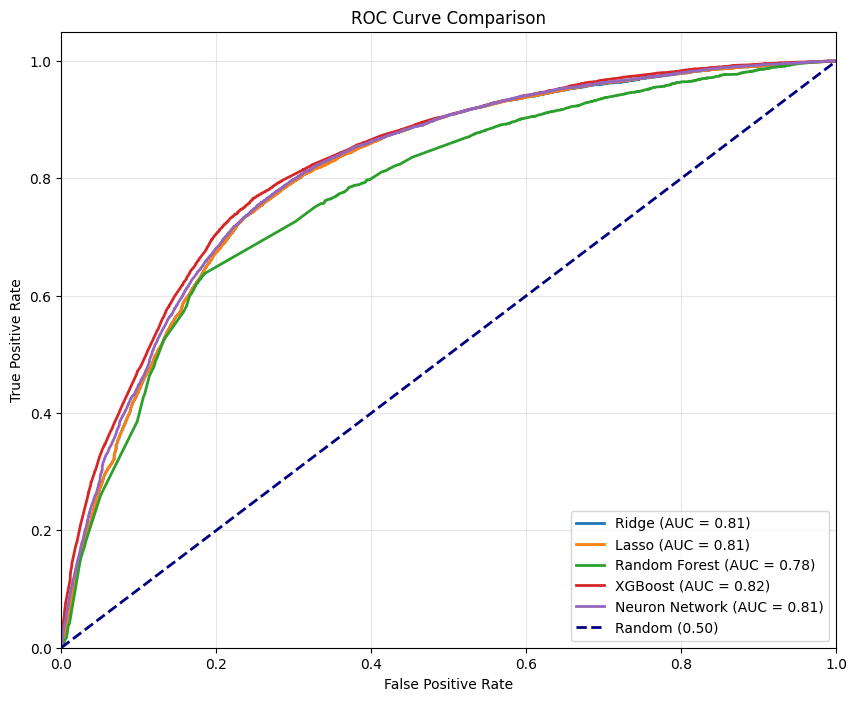

Precision-Recall Curve saved to: pr_curve_plot.png


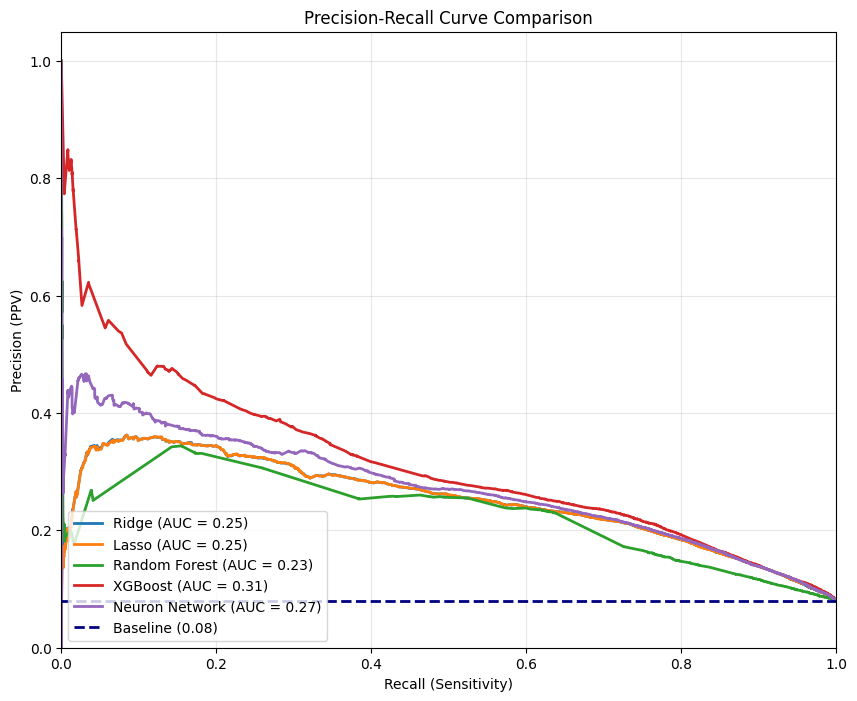

In [10]:
import os
import matplotlib.pyplot as plt
import pandas as pd

# 1. Save 
if 'results_table' in locals() and results_table:
    res_df = pd.DataFrame(results_table).sort_values(by="PR-AUC", ascending=False)
    
    csv_path = os.path.join(FOLDER_PATH, "final_comprehensive_results.csv")
    res_df.to_csv(csv_path, index=False)
    print(f"Results table saved to: {csv_path}")

    print("\nTop Models by PR-AUC:")
    print(res_df[['Model', 'PR-AUC', 'ROC-AUC', 'F1']].head())


# 2. Plot & Save ROC Curve 
plt.figure(figsize=(10, 8))

for name, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Save ROC Plot
roc_path = "roc_curve_plot.png"
plt.savefig(roc_path, dpi=300, bbox_inches='tight')
print(f"\nROC Curve saved to: {roc_path}")
plt.show() # Show in notebook


# 3. Plot & Save Precision-Recall Curve
plt.figure(figsize=(10, 8))

for name, (recall, precision, pr_auc) in pr_curves.items():
    plt.plot(recall, precision, lw=2, label=f'{name} (AUC = {pr_auc:.2f})')

if 'y_test' in locals():
    baseline = sum(y_test) / len(y_test)
    plt.axhline(y=baseline, color='navy', lw=2, linestyle='--', label=f'Baseline ({baseline:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)

# Save PR Plot
pr_path = "pr_curve_plot.png"
plt.savefig(pr_path, dpi=300, bbox_inches='tight')
print(f"Precision-Recall Curve saved to: {pr_path}")
plt.show() 

In [11]:
Y


<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 1652565 stored elements and shape (661271, 10488)>

In [12]:
X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 3235128 stored elements and shape (661271, 5286)>

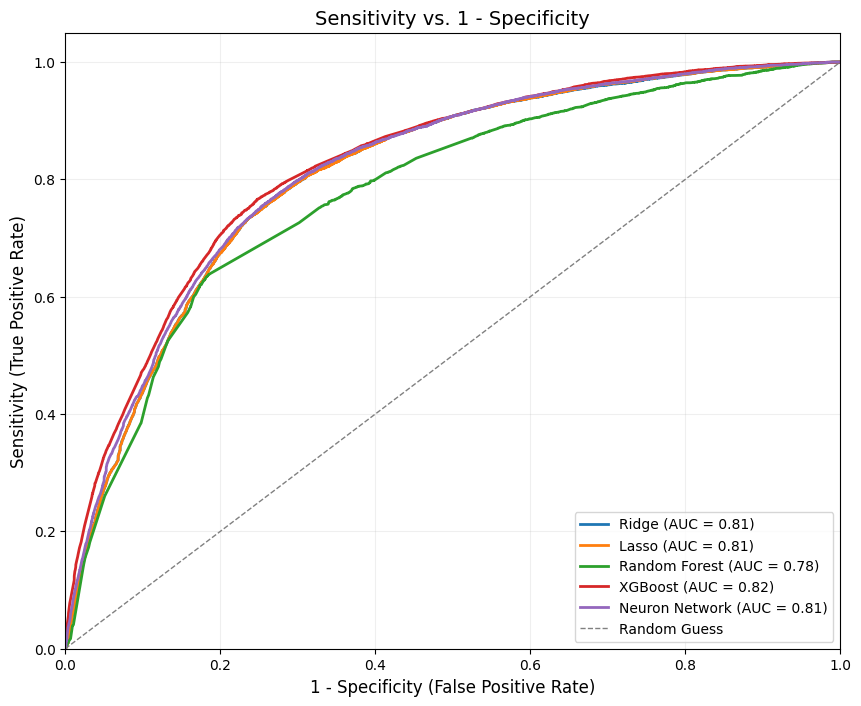

In [13]:
import matplotlib.pyplot as plt

# --- Plot Sensitivity vs. 1 - Specificity ---
plt.figure(figsize=(10, 8))

# Iterate through the data stored in your existing roc_curves dictionary
for name, (fpr, tpr, roc_auc) in roc_curves.items():
    # fpr is effectively 1 - Specificity
    # tpr is Sensitivity
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot the random guess line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Guess')

# Aesthetics matching the requested style
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=12)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize=12)
plt.title('Sensitivity vs. 1 - Specificity', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.2)

# Save and Show
plt.savefig("sensitivity_specificity_plot.png", dpi=300, bbox_inches='tight')
plt.show()

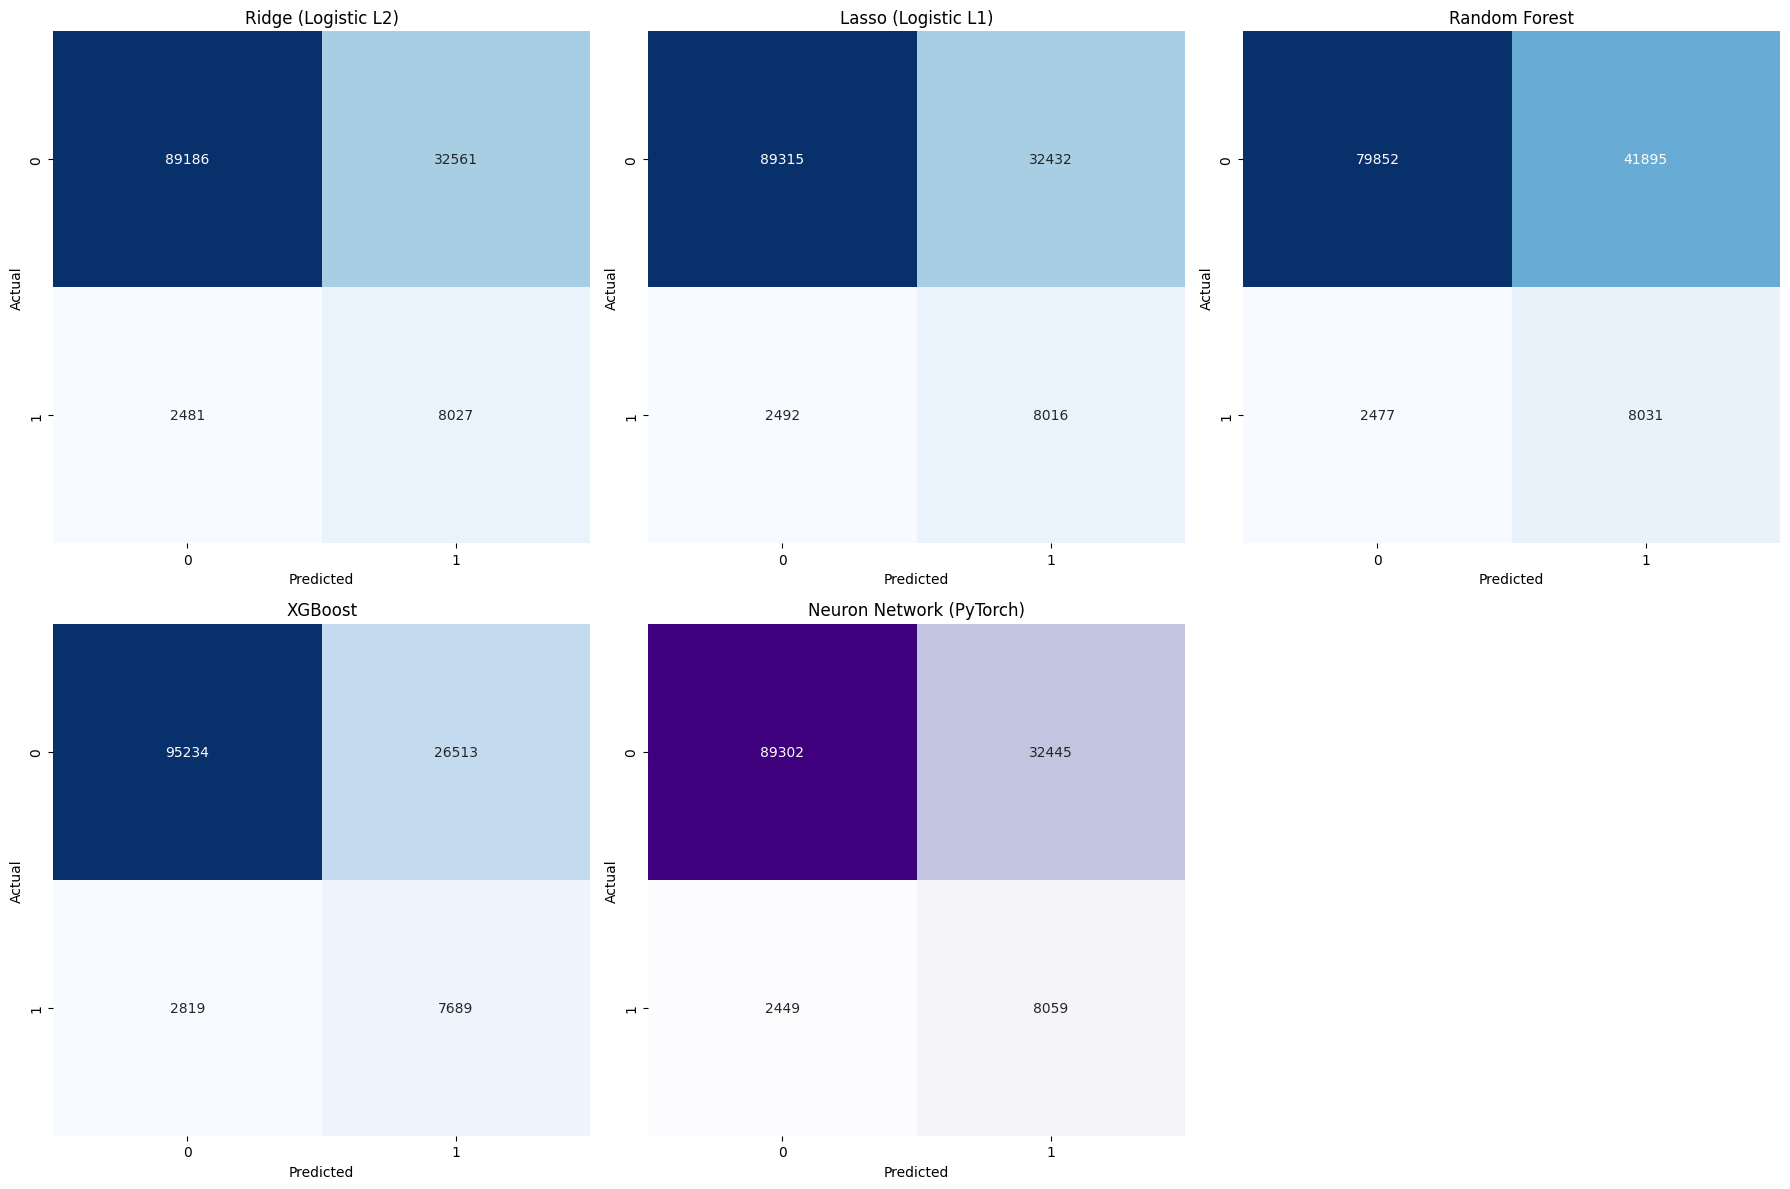

In [14]:
!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import torch


# 1. Setup Plot Grid (2 Rows, 3 Columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten() # Flatten to access easily by index

# 2. Define Standard Models (Sklearn/XGBoost)
# These variables must match the ones named in your previous cells
standard_models = {
    "Ridge (Logistic L2)": ridge,
    "Lasso (Logistic L1)": lasso,
    "Random Forest": rf,
    "XGBoost": xgb_model
}

# 3. Plot Standard Models
for i, (name, model) in enumerate(standard_models.items()):
    # Predict Probabilities
    # Column 1 contains probabilities for the positive class
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Convert to Binary Class (0 or 1) using 0.5 threshold
    y_pred = (y_prob > 0.5).astype(int)
    
    # Compute Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
    axes[i].set_title(f"{name}")
    axes[i].set_ylabel('Actual')
    axes[i].set_xlabel('Predicted')

# 4. Plot PyTorch Model (Special Handling)
# We need to regenerate predictions since they aren't stored as a simple variable
pt_preds = []
model_pt.eval()
with torch.no_grad():
    for xb, _ in test_dl:
        xb = xb.to(device)
        # Get probabilities
        batch_probs = torch.sigmoid(model_pt(xb)).cpu().numpy().flatten()
        pt_preds.extend(batch_probs.tolist())

# Convert PyTorch probs to Binary
y_pred_pt = (np.array(pt_preds) > 0.5).astype(int)
cm_pt = confusion_matrix(y_test, y_pred_pt)

# Plot PyTorch on the 5th subplot (index 4)
sns.heatmap(cm_pt, annot=True, fmt='d', cmap='Purples', cbar=False, ax=axes[4])
axes[4].set_title("Neuron Network (PyTorch)")
axes[4].set_ylabel('Actual')
axes[4].set_xlabel('Predicted')

# 5. Formatting
# Remove the empty 6th subplot
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()